In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


In [2]:
pdb='./ubq/ubq.pdb'
trajectory='./ubq/ubq.desres.s500.dcd'
outdir='./output'

if not os.path.exists('outdir'):
    os.makedirs('outdir')


trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [35]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'AL

In [38]:
dssp_full=md.compute_dssp(trj,simplified=False)

residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)

In [36]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?**

From the figure we can see that the $\alpha$ helix “unwinded” in these frames.

<img src="./Figure 1.png" alt="image1" width="50%" height="auto">

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

In [39]:
from scipy.optimize import curve_fit
time=np.linspace(0,1000,trj.n_frames)


def model_func(x, a, b):
    return a*np.exp(-b * x)

def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)




def get_correlation_time(res,item):
    lags = range(100)
    if res in dihedral_dict[item].keys():
        phi_acf=autocorr1(dihedral_dict[item][res],lags)
        
        selected_phi_acf = phi_acf[phi_acf>0.1] # Ignore the tail 

        if len(selected_phi_acf) > 4:
            popt, pcov = curve_fit(model_func,range(len(selected_phi_acf)),selected_phi_acf)

            return 1/popt[1] * 0.1




phi_time_dict = {}
psi_time_dict = {}
chi1_time_dict = {}
chi2_time_dict = {}


for res in residue_num:

    phi_tau = get_correlation_time(res,"phi")
    psi_tau = get_correlation_time(res,"psi")
    chi1_tau = get_correlation_time(res,"chi1")
    chi2_tau = get_correlation_time(res,"chi2")

    if phi_tau:
        phi_time_dict[res] = phi_tau
    

    if psi_tau:
        psi_time_dict[res] = psi_tau

    if chi1_tau:
        chi1_time_dict[res] = chi1_tau
    
    if chi2_tau:
        chi2_time_dict[res] = chi2_tau


In [40]:
for res in phi_time_dict.keys():
    if phi_time_dict[res] > 10:
        print("{0} phi: {1:.2f}  us ".format(res, phi_time_dict[res]))

print("\n")

for res in psi_time_dict.keys():
    if psi_time_dict[res] > 10:
        print("{0} psi: {1:.2f}  us ".format(res, psi_time_dict[res]))

print("\n")

for res in chi1_time_dict.keys():
    if chi1_time_dict[res] > 10:
        print("{0} chi1: {1:.2f}  us ".format(res, chi1_time_dict[res]))

print("\n")

for res in chi2_time_dict.keys():
    if chi2_time_dict[res] > 10:
        print("{0} chi2: {1:.2f}  us ".format(res, chi2_time_dict[res]))


10 phi: 19.76  us 
31 phi: 29.17  us 
33 phi: 17.22  us 
34 phi: 28.62  us 
35 phi: 39.53  us 


13 psi: 24.96  us 
30 psi: 46.67  us 
31 psi: 15.93  us 
32 psi: 21.88  us 
33 psi: 26.45  us 
34 psi: 50.03  us 
36 psi: 15.18  us 


36 chi1: 10.80  us 




The figure illustrates that residues 31-35 are involved in both unfolding and folding processes within the trajectory. Consequently, these residues exhibit substantial deviations in RMSD compared to the mean values, resulting in an extended relaxation time.

<img src="./Figure 2.png" alt="image1" width="50%" height="auto">

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

100%|██████████| 75/75 [00:00<00:00, 89.70it/s]


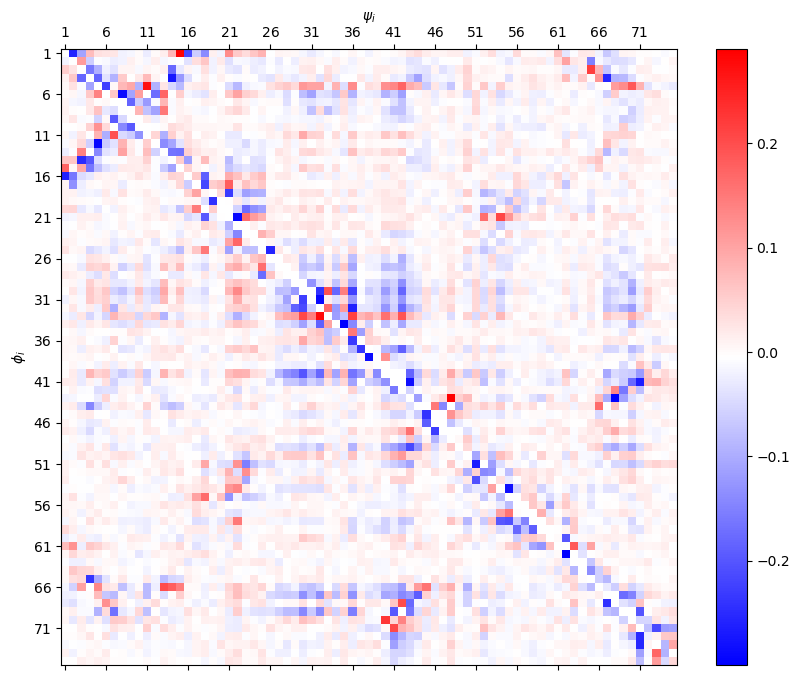

In [41]:
from tqdm import trange

def circular_mean(alpha):
    return np.arctan2(np.sum(np.sin(alpha)), np.sum(np.cos(alpha)))


def cc_coefficient(alpha,beta):
    alpha_mean = circular_mean(alpha)
    beta_mean = circular_mean(beta)

    fenzi = np.sum(np.sin(alpha-alpha_mean)*np.sin(beta-beta_mean))
    fenmu = np.sqrt(np.sum(np.sin(alpha-alpha_mean)**2)*np.sum(np.sin(beta-beta_mean)**2))

    return fenzi/fenmu


def plot_phi_psi_cc(condition = None, cut_off = 0.3):

    num_phi = len(dihedral_dict["phi"].keys())
    num_psi = len(dihedral_dict["psi"].keys())

    correlation_matrix = np.zeros((num_phi, num_psi))

    for i in trange(num_phi):
        for j in range(num_psi):
            phi_res = list(dihedral_dict["phi"].keys())[i]
            psi_res = list(dihedral_dict["psi"].keys())[j]
            
            if condition is not None:

                phi_array = dihedral_dict["phi"][phi_res][condition]
                psi_array = dihedral_dict["psi"][psi_res][condition]
            else:
                phi_array = dihedral_dict["phi"][phi_res]
                psi_array = dihedral_dict["psi"][psi_res]
            
            correlation_matrix[i, j] = cc_coefficient(phi_array, psi_array)

    masked_correlation_matrix = np.where((correlation_matrix > -cut_off) & (correlation_matrix < cut_off), correlation_matrix, np.nan)


    fig, ax = plt.subplots(figsize=(10, 8))

    cax =  ax.matshow(masked_correlation_matrix, cmap = "bwr")

    fig.colorbar(cax)

    ax.set_xticks(np.arange(0, masked_correlation_matrix.shape[1], 5))  
    ax.set_yticks(np.arange(0, masked_correlation_matrix.shape[0], 5))  

    ax.set_xticklabels(np.arange(1, masked_correlation_matrix.shape[1] + 1, 5))
    ax.set_yticklabels(np.arange(1, masked_correlation_matrix.shape[0] + 1, 5))

    ax.set_xlabel("$\psi_{i}$")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("$\phi_{i}$")
    plt.show()


plot_phi_psi_cc()

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

In [43]:
hbonds = md.baker_hubbard(trj, periodic=False)


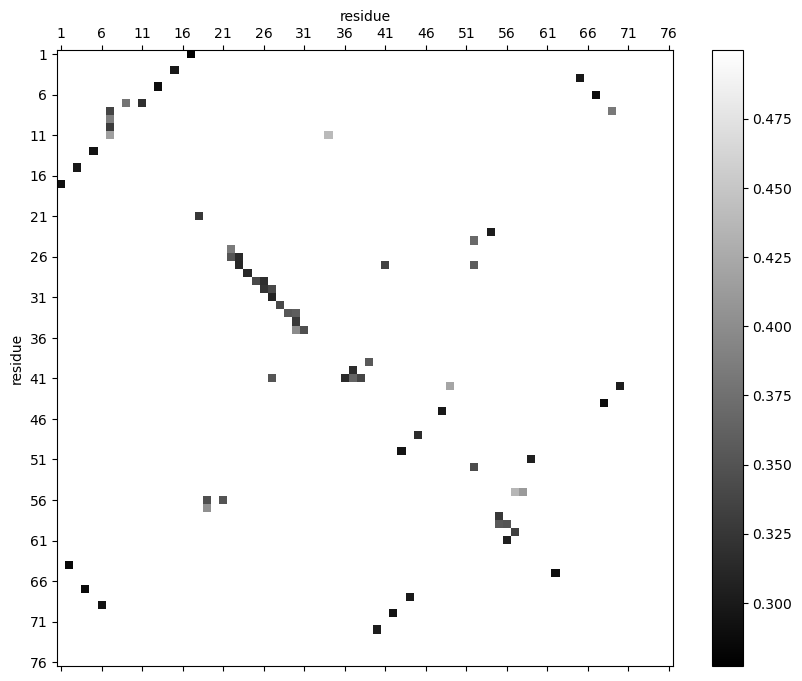

In [44]:
def plot_hbond(condition = None, cut_off = 0.5):

    distance_matrix = np.zeros((len(residue_num), len(residue_num)))
    for hbond in hbonds:
        i = trj.topology.atom(hbond[0]).residue.resSeq
        j = trj.topology.atom(hbond[2]).residue.resSeq

        if condition is not None:

            da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)[condition].mean()
        else: 
            da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False).mean()

        distance_matrix[i-1,j-1] = da_distance

    masked_distance_matrix = np.where((distance_matrix > 0) & (distance_matrix < cut_off), distance_matrix, np.nan)
    # Plotting the correlation matrix
    fig, ax = plt.subplots(figsize=(10, 8))

    cax =  ax.matshow(masked_distance_matrix, cmap = "gist_gray")

    fig.colorbar(cax)

    ax.set_xticks(np.arange(0, masked_distance_matrix.shape[1], 5))  
    ax.set_yticks(np.arange(0, masked_distance_matrix.shape[0], 5))  

    ax.set_xticklabels(np.arange(1, masked_distance_matrix.shape[1] + 1, 5))
    ax.set_yticklabels(np.arange(1, masked_distance_matrix.shape[0] + 1, 5))

    ax.set_xlabel("residue")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("residue")
    plt.show()

plot_hbond()

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

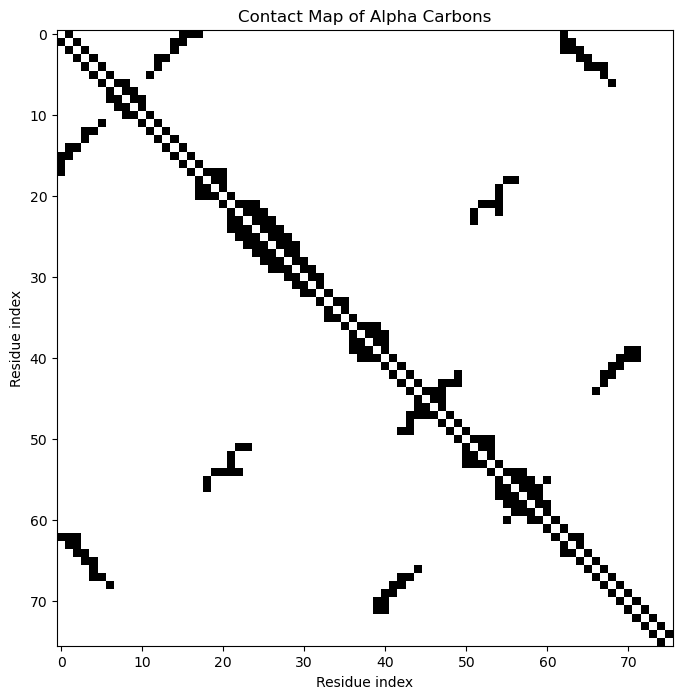

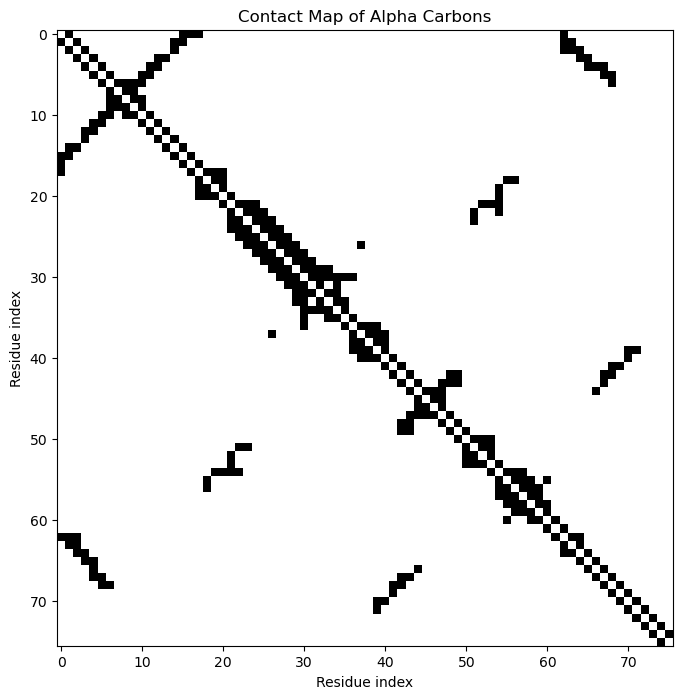

In [45]:
def plot_contact_map(condition = None, cut_off = 0.6):


    alpha_carbons = trj.topology.select('name CA')

    alpha_res_dict = {}

    for i,alpha_carbon in enumerate(alpha_carbons):
        alpha_res_dict[alpha_carbon] = i


    num_residues = len(residue_num)
    pair_indices = []
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            pair_indices.append([alpha_carbons[i], alpha_carbons[j]])

    pair_indices = np.array(pair_indices)

    if condition is not None:

        distances = md.compute_distances(trj, pair_indices)[condition].mean(axis = 0)

    else:
        
        distances = md.compute_distances(trj, pair_indices).mean(axis = 0)


    contact_map = np.zeros((num_residues, num_residues))
    for k, (i, j) in enumerate(pair_indices):
        
        contact_map[alpha_res_dict[i], alpha_res_dict[j]] = contact_map[alpha_res_dict[j], alpha_res_dict[i]] = 1 if distances[k] < cut_off else 0

    # Plotting the contact map
    plt.figure(figsize=(10, 8))
    plt.imshow(contact_map, cmap='Greys', interpolation='none')

    plt.title('Contact Map of Alpha Carbons')
    plt.xlabel('Residue index')
    plt.ylabel('Residue index')
    plt.show()

plot_contact_map(condition=range(6500,7500))
plot_contact_map(condition=list(range(6500))+list(range(7500,10088)))


From the comparison of the contact maps, we can see that the unfolded region changed. 

<img src="./Figure 3.png" alt="image1" width="100%" height="auto">

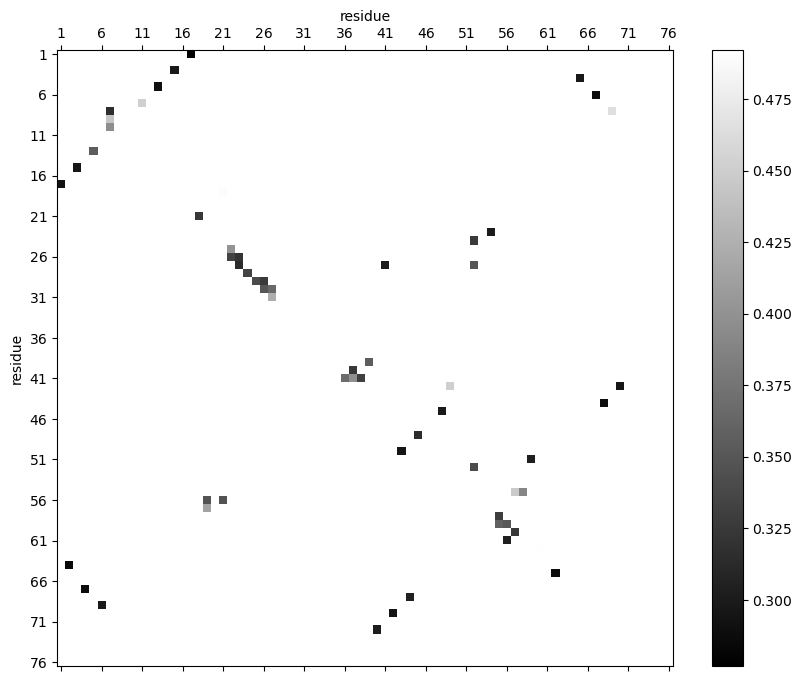

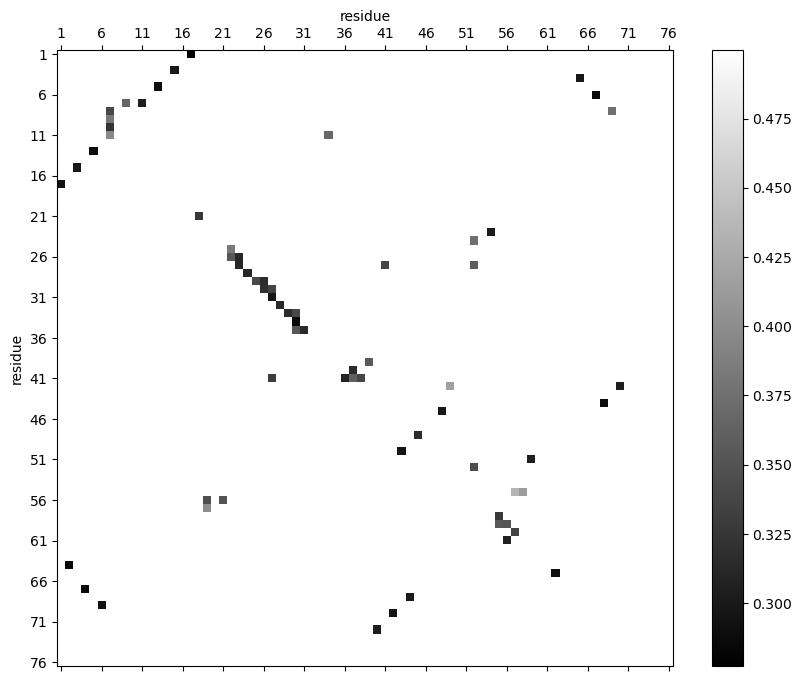

In [13]:
plot_hbond(condition=range(6500,7500))
plot_hbond(condition=list(range(6500))+list(range(7500,10088)))


Same in the case of hydrogen bonding

<img src="./Figure 4.png" alt="image1" width="100%" height="auto">

100%|██████████| 75/75 [00:00<00:00, 128.53it/s]


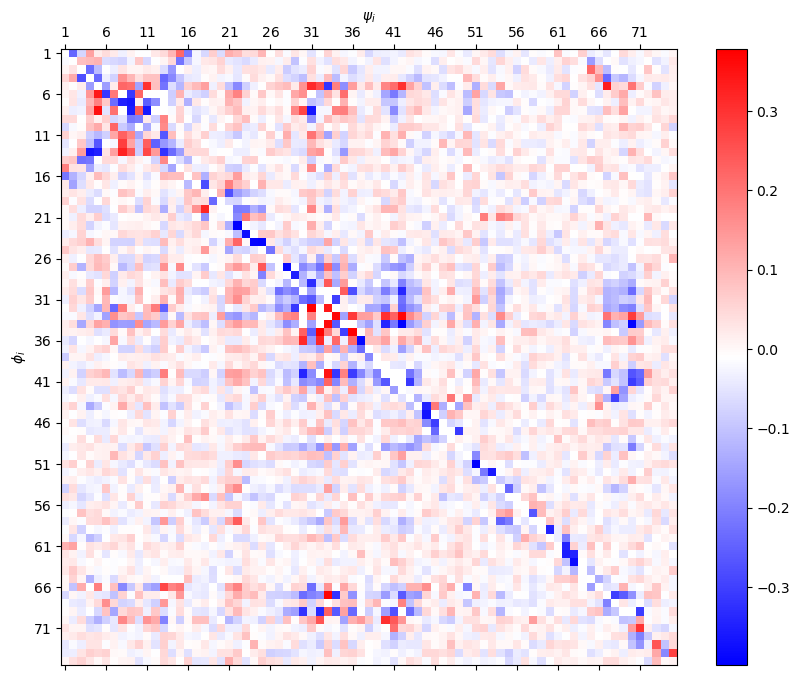

100%|██████████| 75/75 [00:03<00:00, 20.84it/s]


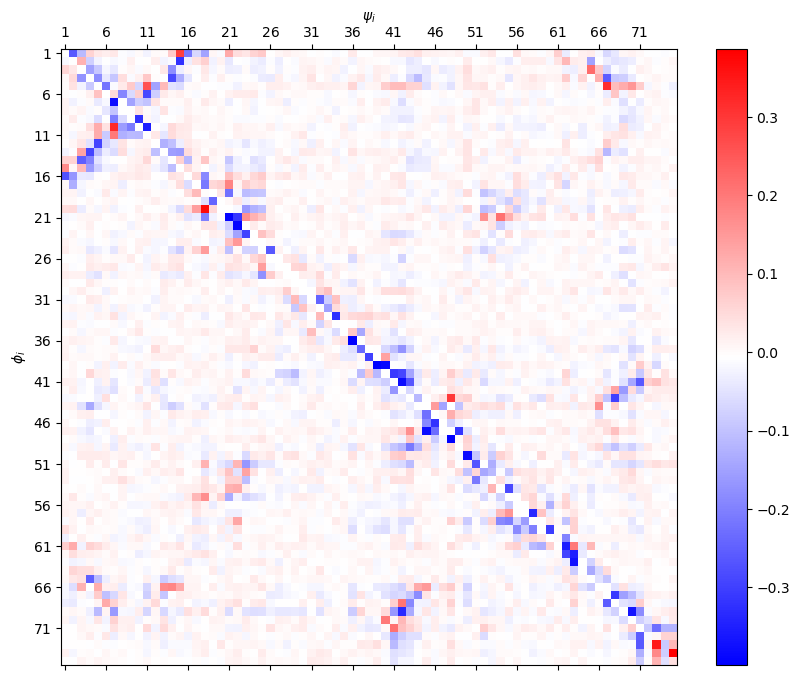

In [14]:
plot_phi_psi_cc(condition=range(6500,7500),cut_off=0.4)
plot_phi_psi_cc(condition=list(range(6500))+list(range(7500,10088)),cut_off=0.4)


In the $\phi-\psi$ plot, there's also difference in 30 ~ 60 region, possibly related to $\alpha-\beta 5$ interaction. They are closer in the unfolded state.

<img src="./Figure 5.png" alt="image1" width="100%" height="auto">

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

(10088, 2)


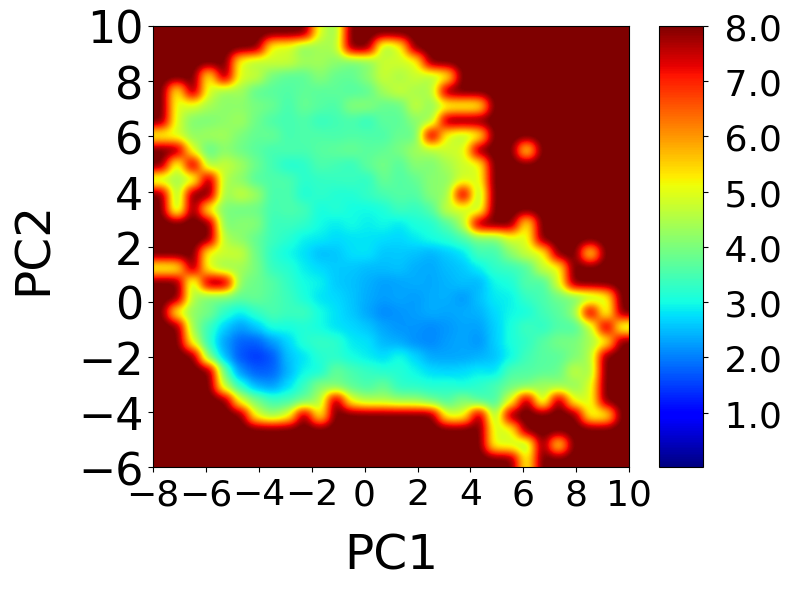

In [31]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)


###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

In [51]:
def get_condition(lower1, upper1,lower2, upper2 ):
    indices = np.where((reduced_cartesian[:, 0] >= lower1) & (reduced_cartesian[:, 0] <= upper1) &
                   (reduced_cartesian[:, 1] >= lower2) & (reduced_cartesian[:, 1] <= upper2))[0]
    
    result = np.full(10088, False, dtype=bool)
    result[indices] = True

    return result

condition_1 = get_condition(-2,6,-4,0)

condition_2 = get_condition(-2, 6,-2, 3)



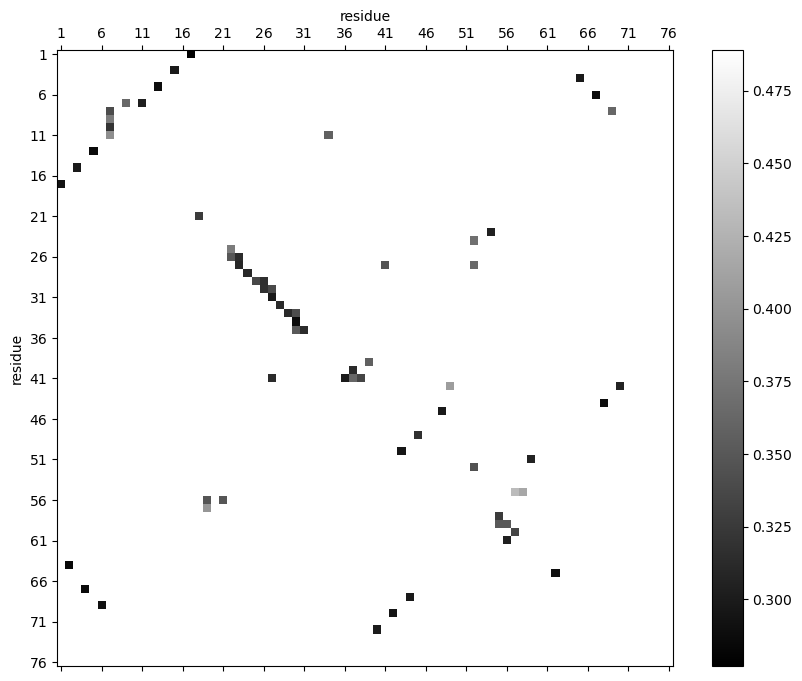

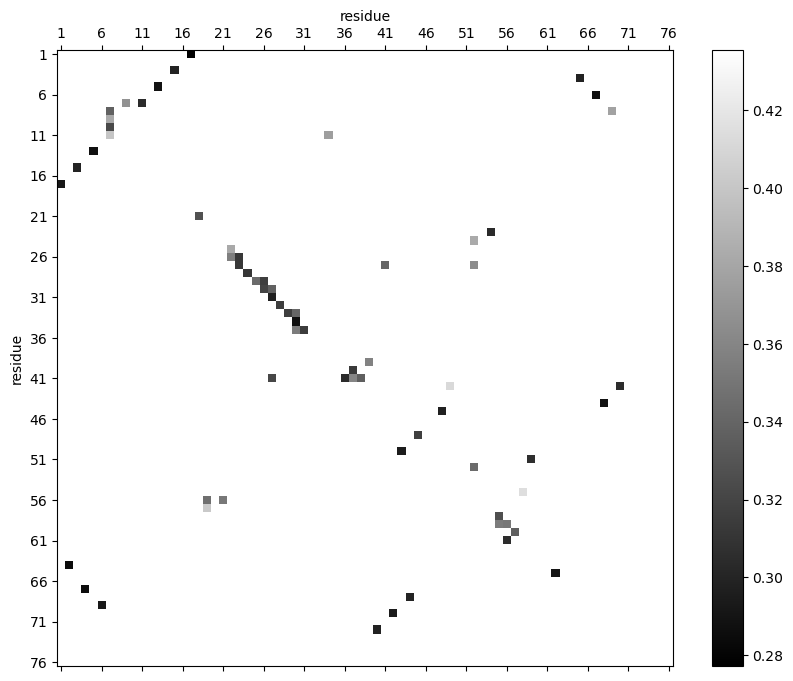

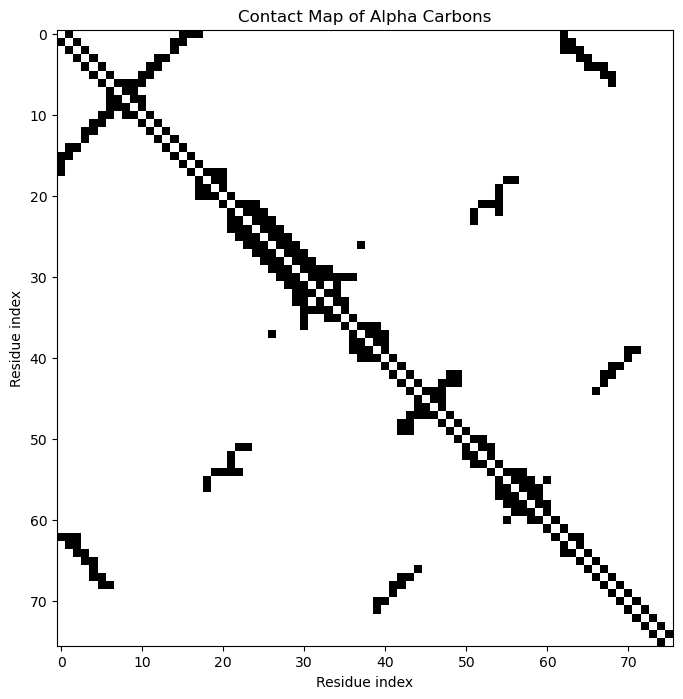

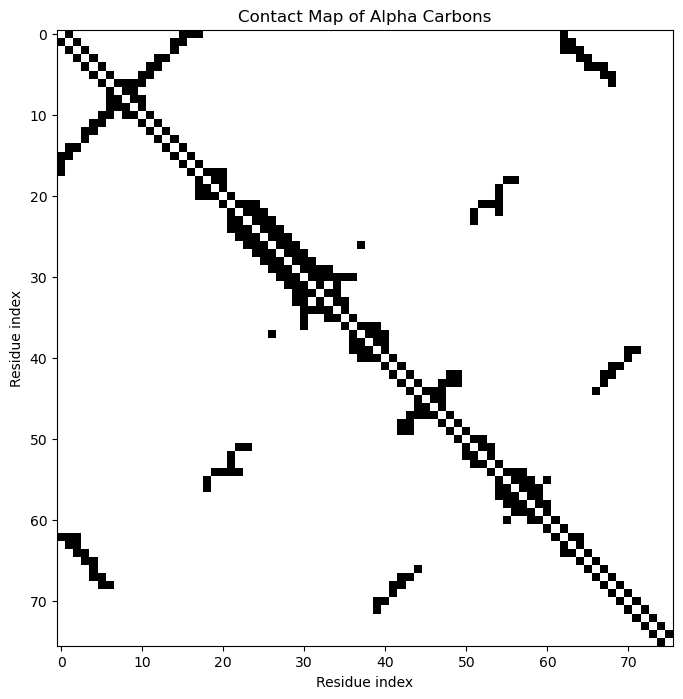

100%|██████████| 75/75 [00:00<00:00, 200.31it/s]


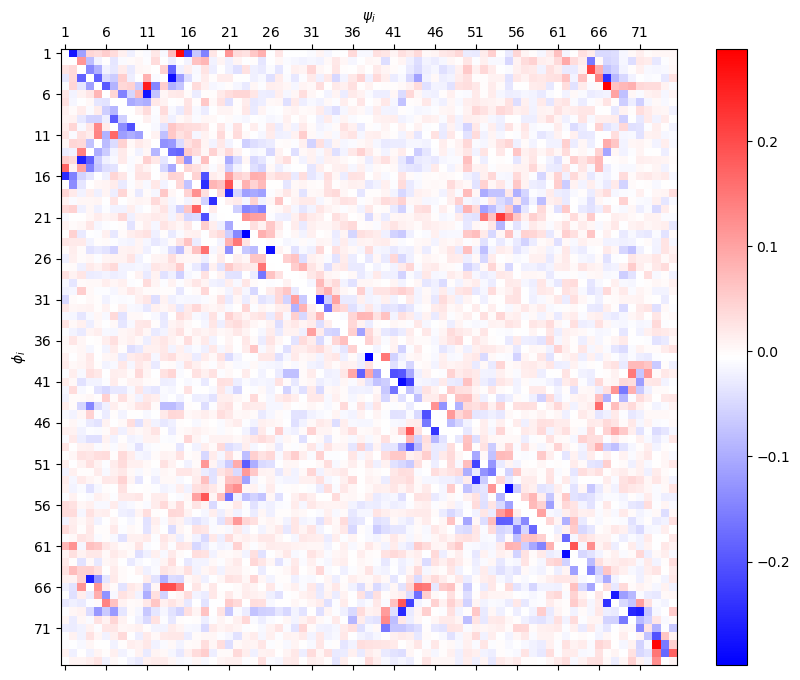

100%|██████████| 75/75 [00:00<00:00, 139.16it/s]


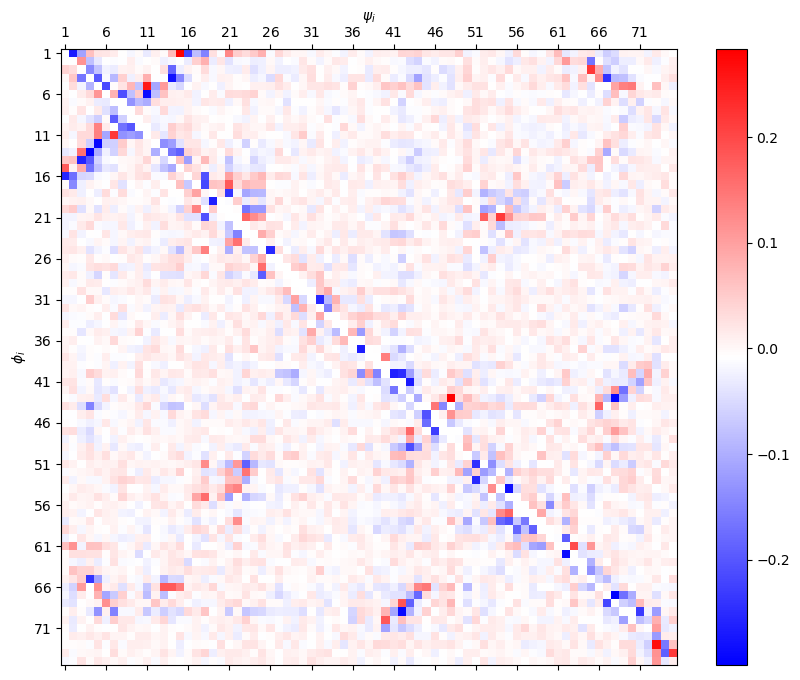

In [52]:
plot_hbond(condition = condition_1)
plot_hbond(condition = condition_2)

plot_contact_map(condition = condition_1)
plot_contact_map(condition = condition_2)

plot_phi_psi_cc(condition = condition_1)
plot_phi_psi_cc(condition = condition_2)

8) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

In [8]:
from tqdm import trange

distances = np.empty((trj.n_frames, trj.n_frames))
for i in trange(trj.n_frames):
    distances[i] = md.rmsd(trj, trj, i)



100%|██████████| 10088/10088 [06:39<00:00, 25.22it/s]


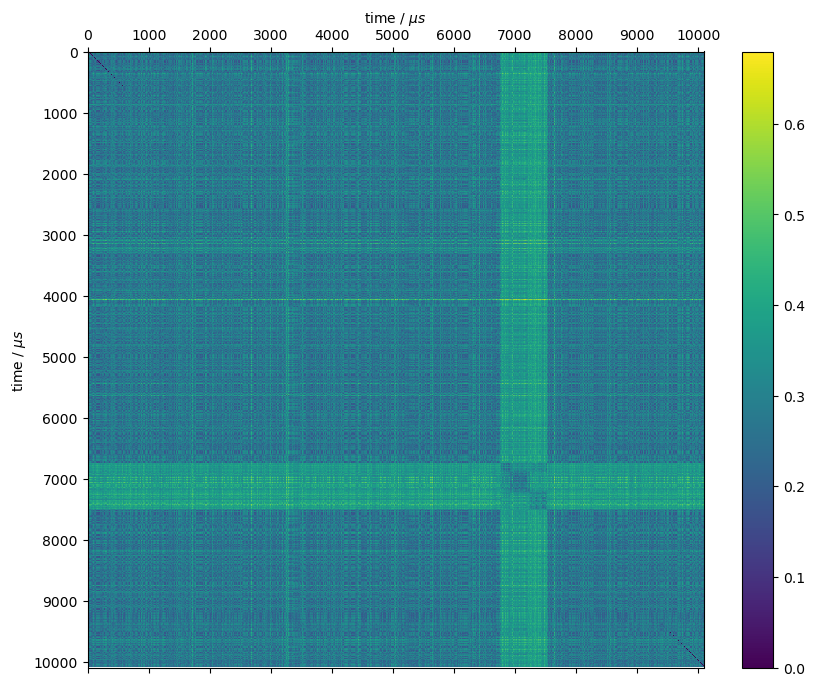

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
cax =  ax.matshow(distances, cmap = "viridis")
plt.grid(False)

fig.colorbar(cax)

ax.set_xticks(np.arange(0, distances.shape[1], 1000))  
ax.set_yticks(np.arange(0, distances.shape[0], 1000))  

ax.set_xticklabels(np.arange(0, distances.shape[1], 1000))
ax.set_yticklabels(np.arange(0, distances.shape[0], 1000))

ax.set_xlabel("time / $\mu s$")
ax.xaxis.set_label_position('top')
ax.set_ylabel("time / $\mu s$")
plt.show()

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)

In [16]:
import scipy.cluster.hierarchy as sch
from tqdm import tqdm

reduced_distances = squareform(distances, checks=False)
linkage = sch.linkage(reduced_distances, method='average')
clusters = sch.fcluster(linkage, t=5, criterion='maxclust')



cluster_list = [[],[],[],[],[]]
for frame_number, cluster_id in enumerate(tqdm(clusters)):
    cluster_list[cluster_id-1].append(frame_number)
    



100%|██████████| 10088/10088 [00:00<00:00, 765345.73it/s]


In [19]:
# Print the cluster population.

frame_num_list = list(map(len,cluster_list))

for i, frame_num in enumerate(frame_num_list):
    print("cluster #{0} contains {1} frames".format(i+1,frame_num))

cluster #1 contains 2 frames
cluster #2 contains 19 frames
cluster #3 contains 9321 frames
cluster #4 contains 18 frames
cluster #5 contains 728 frames


10) Visualize the most populated clusters from your clustering analysis

In [29]:
def extract_distance_matrix(mother, frame_list):

    son = np.zeros((len(frame_list),len(frame_list)))

    for i, frame_i in enumerate(frame_list):
        for j, frame_j in enumerate(frame_list):
            son[i,j] = mother[frame_i,frame_j]
    

    return son

def represent_index(matrix, beta=1):

    index = np.exp(-beta*matrix / matrix.std()).sum(axis=1).argmax()

    return index


def get_represent_from_cluster(frame_list):

    son_distance_matrix = extract_distance_matrix(distances, frame_list)

    represent = represent_index(son_distance_matrix)
    return frame_list[represent]

print(get_represent_from_cluster(cluster_list[2]))
print(get_represent_from_cluster(cluster_list[4]))

1457
7128


<img src="./Figure 6.png" alt="image1" width="100%" height="auto">

They corresponding to folded and unfolded state respectively.